In [1]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
import pandas as pd
import torch as T
import numpy as np

In [2]:
data = load_digits()
x = data['data']
y = data['target']

In [3]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)

In [4]:
# Data Set
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch as T
import torch.optim as optim
import torch.nn.functional as F

class DS(Dataset):
  def __init__(self, x, y) -> None:
    super().__init__()
    
    self.x = x
    self.y = y

  def __len__(self):
    return len(self.y)

  def __getitem__(self, idx):
    return self.x[idx,:], self.y[idx]


In [5]:
class ANNModel(nn.Module):
  def __init__(self, input_dims=7, out_dims=10, lr=1e-4) -> None:
    super().__init__()

    self.input_dims = input_dims
    self.output_dims = out_dims
    n_nodes = 1024

    self.fc1 = nn.Linear(self.input_dims, n_nodes)
    self.fc2 = nn.Linear(n_nodes, n_nodes)
    self.fc3 = nn.Linear(n_nodes, n_nodes)
    self.fout = nn.Linear(n_nodes, self.output_dims)

    self.dropout = nn.Dropout(0.0)

    self.optimizer = optim.Adam(self.parameters(), lr=lr)
    self.loss = nn.CrossEntropyLoss()
    self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
    self.to(self.device)

  def forward(self, x):
    x = x.to(self.device)
    x = x.to(T.float32)

    out = self.dropout(F.leaky_relu(self.fc1(x)))
    out = self.dropout(F.leaky_relu(self.fc2(out)))
    out = F.leaky_relu(self.fc3(out))
    out = self.fout(out)
    out = F.softmax(out, dim=1)

    return out

  def learn(self, x, y):
    x = x.to(self.device)
    x = x
    y = y.to(self.device)
    y = y.to(T.int64)

    self.optimizer.zero_grad()

    y_pred = self.forward(x)
    # print('y_pred ', y_pred)
    loss = self.loss(y_pred, y)
    loss.backward()
    self.optimizer.step()

    r_pred = T.argmax(y_pred, dim=1)
    err = T.sum(r_pred != y)
    
    # return loss.item()
    return err.item()


In [6]:
training_set = DS(x_train, y_train)
training_dataloader = DataLoader(training_set, batch_size=128, shuffle=True)

test_set = DS(x_test, y_test)
test_dataloader = DataLoader(test_set, batch_size=128, shuffle=False)


In [7]:
model = ANNModel(input_dims=x.shape[1], out_dims=len(np.unique(y_train)), lr=1e-3)

losses = []
n_episodes = 100
for n_episode in range(n_episodes):
  loss = 0
  for x, y in training_dataloader:
    loss += model.learn(x, y)
  losses.append(loss)
  

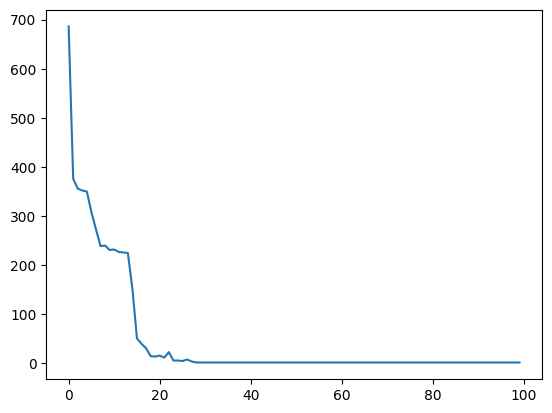

In [8]:
import matplotlib.pyplot as plt
plt.plot(losses)